## Task description
Abstractive + extractive meeting transcripts summarization

## Base model

GPT-2 (small)


## Data
AMI corpus

## Metrics
ROUGE (ROUGE-1, ROUGE-2, ROUGE-L)

## Required imports

In [5]:
import re
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from torch.utils.data import DataLoader
import torch

from torch.utils.data import Dataset
import pandas as pd

from torch.optim import Adam
from tqdm.auto import tqdm

In [6]:
device = torch.device("cuda:0")

## GPT-2 multitask fine-tuning (autoregressive)

**Algorithm**: train GPT-2 in autoregressive style using special tokens to separate texts and summaries during training.


In this notebook, the GPT-2 model was fine-tuned on AMI corpus samples that were less than 1024 tokens (for text + abstractive summary + extractive summary sequences).

### Load model&tokenizer, add special tokens

In [9]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)

tokenizer.add_special_tokens({"pad_token": "<pad>",
                              "bos_token": "<startofstring>",
                              "eos_token": "<endofstring>"
                             })

# separate token for summaries
tokenizer.add_tokens(["<abstractive>"])
tokenizer.add_tokens(["<extractive>"])
#tokenizer.add_tokens(["<summary:>"])

model.resize_token_embeddings(len(tokenizer))

Embedding(50262, 768)

### DataSet class

In [8]:
class SummaryDataset(Dataset):
    def __init__(self, path:str, tokenizer):
        self.data = pd.read_csv(path)
        self.texts = self.data['text'].values
        self.abstractive = self.data['abstract'].values
        self.extractive = self.data['extractive'].values

        self.X = []

        for text, extractive,  abstractive in zip(self.texts, self.extractive, self.abstractive):
            # add special tokens to each sample
            self.X.append("<startofstring> " + text + " <abstractive> " + abstractive +  " <extractive> " + extractive + " <endofstring>")

        print(self.X[0])

        self.X_encoded = tokenizer(self.X, max_length=1024, truncation=True, padding="max_length", return_tensors="pt")
        self.input_ids = self.X_encoded['input_ids']
        self.attention_mask = self.X_encoded['attention_mask']

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (self.input_ids[idx], self.attention_mask[idx])

In [12]:
dataset = SummaryDataset('ami_train_1024.csv', tokenizer)

<startofstring> UI: Okay .
ID: Or you get it .
ID: Okay .
UI: No I don't think so
UI: it has to be like that
UI: yeah
UI: and you have to adjust the length .
UI: Okay , and then .
PM: So
PM: we uh we will wait for Anna , a few minutes .
UI: Yeah , s yeah , um .
ID: 
ID: Mm .
ID: Yours is well
UI: I think you can put anywhere you want , actually .
ID: Yeah
ID: but the the mic should not
UI: I thin
UI: It's not a directional mic , anyway .
ID: 
PM: I think it should work like this .
PM: So I will try to get my presentation running .
UI: Uh .
ID: Yeah .
UI: Yeah .
PM: Mm .
ID: Mm .
ID: Can't help you with that .
UI: Last .
PM: It's no matter .
ID: Okay ,
ID: it's y
ID: yeah .
PM: No problem .
PM: Ah
PM: yes .
ID: Right .
UI: Okay .
ID: Then press uh al
UI: Okay .
ID: This .
ID: You know ?
PM: I don't know .
PM: Just try .
UI: 'Kay .
PM: On this normal
ID: Oh oh .
UI: Alt F five .
PM: Good .
PM: Doesn't appear on the screen here .
ID: 
ID: Right well
PM: Oh .
ID: Wow . Amazing .
ID: It's w

In [13]:
len(dataset.__getitem__(0)[0])

1024

In [14]:
dataloader = DataLoader(dataset, batch_size=8)

### 1.3 Training Setup

In [15]:
optim = Adam(model.parameters(), lr=1e-3)

In [17]:
def train(dataloader, model, optim):

  epochs = 100
  losses = []
  rouges = []

  for i in tqdm(range(epochs)):
    print(f'Epoch: {i+1} started')
    total_loss = 0
    num_batches = 0

    for X, a in tqdm(dataloader):
      X = X.to(device)
      a = a.to(device)
      optim.zero_grad()
      loss = model(X, attention_mask=a, labels=X).loss
      loss.backward()
      optim.step()

      total_loss += loss.item()  # Accumulate the batch loss
      num_batches += 1
      losses.append(loss.item())

    avg_loss = total_loss / num_batches  # Calculate average loss for the epoch
    print(f'Epoch: {i+1}, Loss: {avg_loss:.4f}')
    #torch.save(model.state_dict(), "model_state.pt")
    if avg_loss <= 0.155:
      model.save_pretrained('gpt2_abstractive_extractive_1024')
      return losses


Train model till reaching the loss less than 0.155

In [ ]:
result = train(dataloader, model, optim)

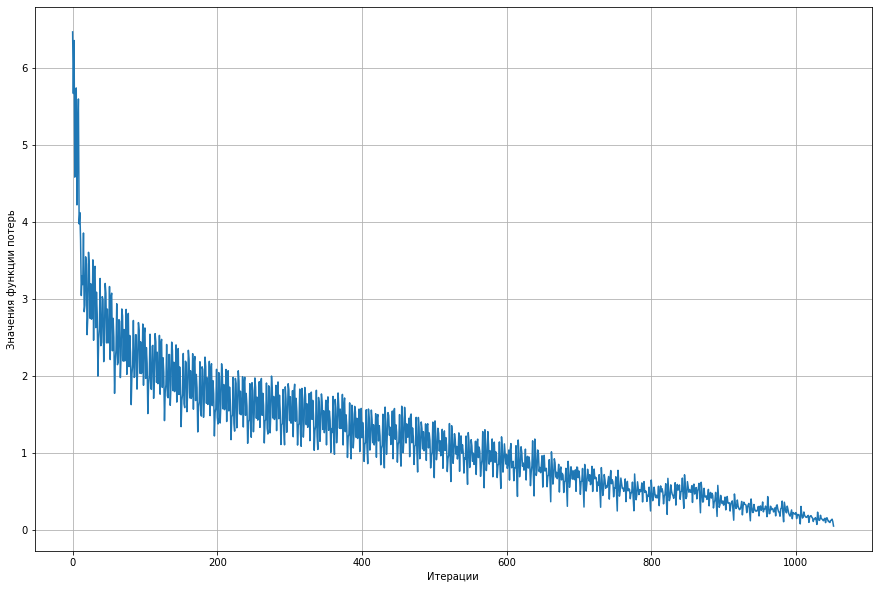

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.plot(result2)
plt.grid()
plt.xlabel('Итерации')
plt.ylabel('Значения функции потерь');